# Prompt Chaining

Prompt chaining decomposes a task into a sequence of steps, where each LLM call processes the output of the previous one. You can add programmatic checks (see "gate” in the diagram below) on any intermediate steps to ensure that the process is still on track.

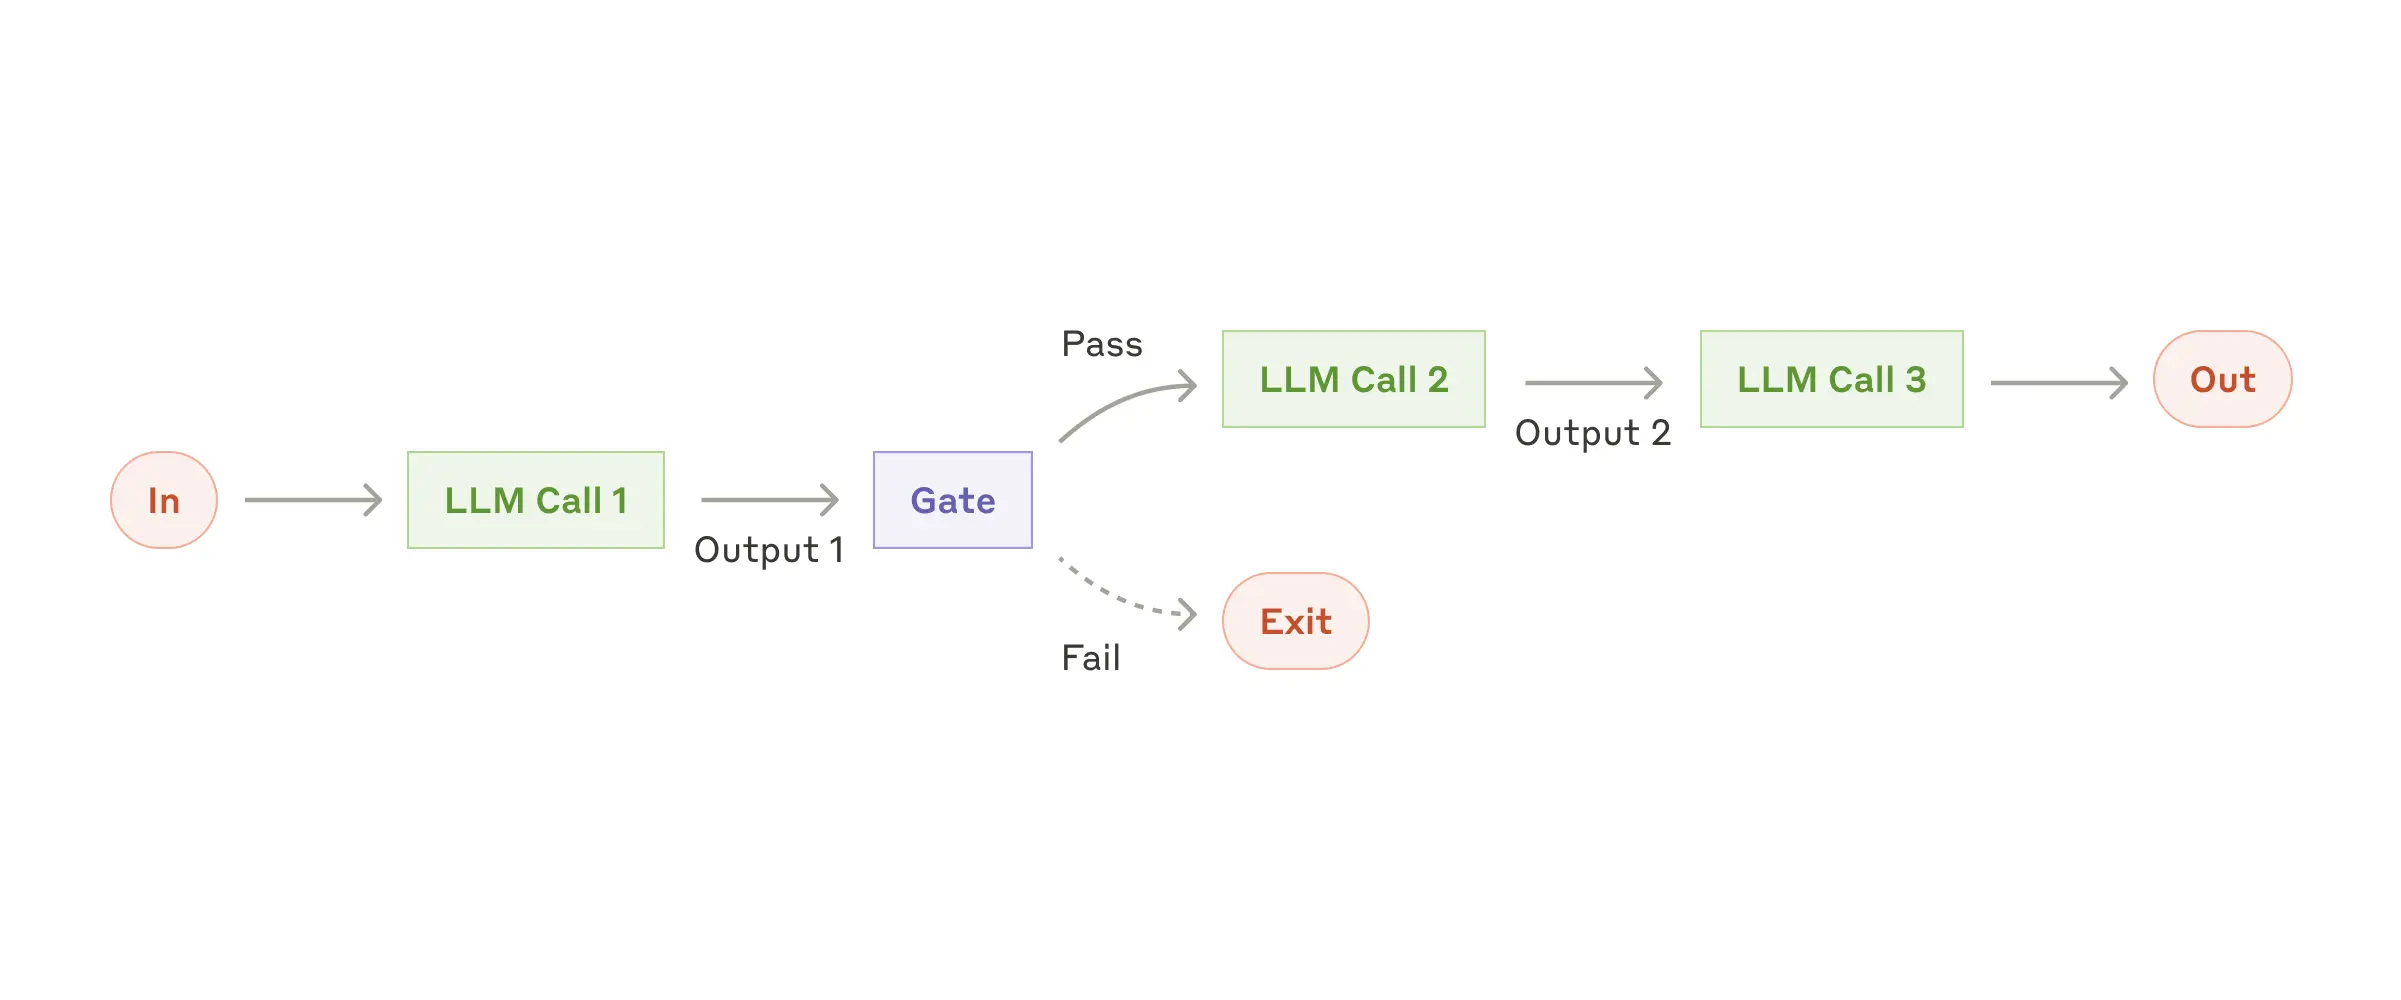

When to use this workflow: This workflow is ideal for situations where the task can be easily and cleanly decomposed into fixed subtasks. The main goal is to trade off latency for higher accuracy, by making each LLM call an easier task.

## Install Packages

In [1]:
!pip install -Uq openai-agents

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.2 MB/s eta 0:00:00


In [2]:
import nest_asyncio
nest_asyncio.apply()

## Config

In [3]:
from agents import (
    AsyncOpenAI,
    OpenAIChatCompletionsModel
)
from google.colab import userdata


In [4]:
gemini_api_key = userdata.get("GEMINI_API_KEY")


# Check if the API key is present; if not, raise an error
if not gemini_api_key:
    raise ValueError("GEMINI_API_KEY is not set. Please ensure it is defined in your .env file.")

#Reference: https://ai.google.dev/gemini-api/docs/openai
external_client = AsyncOpenAI(
    api_key=gemini_api_key,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/",
)

model = OpenAIChatCompletionsModel(
    model="gemini-2.0-flash",
    openai_client=external_client
)

In [5]:
from agents import set_default_openai_client, set_tracing_disabled
set_default_openai_client(external_client)
set_tracing_disabled(True)

## Implement Prompt Chaining Pattern

Here we have a deterministic flow, where each step is performed by an agent.
1. The first agent generates a story outline
2. We feed the outline into the second agent
3. The second agent checks if the outline is good quality and if it is a scifi story
4. If the outline is not good quality or not a scifi story, we stop here
5. If the outline is good quality and a scifi story, we feed the outline into the third agent
6. The third agent writes the story

------------------------------------------------

In [6]:
import asyncio
from pydantic import BaseModel
from agents import Agent, Runner

In [7]:
story_outline_agent = Agent(
    name="story_outline_agent",
    instructions="Generate a very short story outline based on the user's input.",
    model=model
)

In [8]:
class OutlineCheckerOutput(BaseModel):
    good_quality: bool
    is_scifi: bool


outline_checker_agent = Agent(
    name="outline_checker_agent",
    instructions="Read the given story outline, and judge the quality. Also, determine if it is a scifi story.",
    output_type=OutlineCheckerOutput,
    model=model
)

story_agent = Agent(
    name="story_agent",
    instructions="Write a short story based on the given outline.",
    output_type=str,
    model=model
)

In [11]:
async def main():
    input_prompt = input("What kind of story do you want? ")

    print("\n1. Generate an outline!\n")
    outline_result = await Runner.run(
        story_outline_agent,
        input_prompt,
    )
    print("[OUTLINE_GENERATED]", outline_result, "\n\n")

    print("\n2. Check the outline!\n")
    outline_checker_result = await Runner.run(
        outline_checker_agent,
        outline_result.final_output,
    )

    print("\n3. Add a gate to stop if the outline is not good quality or not a scifi story\n")
    assert isinstance(outline_checker_result.final_output, OutlineCheckerOutput)
    if not outline_checker_result.final_output.good_quality:
        print("Outline is not good quality, so we stop here.")
        exit(0)

    if not outline_checker_result.final_output.is_scifi:
        print("Outline is not a scifi story, so we stop here.")
        exit(0)

    print("Outline is good quality and a scifi story, so we continue to write the story.")

    print("\n4. Write the story\n")
    story_result = await Runner.run(
        story_agent,
        outline_result.final_output,
    )
    print(f"Story: {story_result.final_output}")

In [12]:
if __name__ == "__main__":
    asyncio.run(main())

What kind of story do you want? An AI Engineer Building Agents for Earth and Mars

1. Generate an outline!

[OUTLINE_GENERATED] RunResult:
- Last agent: Agent(name="story_outline_agent", ...)
- Final output (str):
    Okay, here's a short story outline based on "An AI Engineer Building Agents for Earth and Mars":
    
    **Title:** (Something like) *Dual Worlds* or *Across the Divide*
    
    **Protagonist:** Anya, a brilliant but driven AI engineer.
    
    **Setting:** Near-future Earth and Mars, with a focus on a remote research facility (either on Earth or Mars, decide which is more impactful).
    
    **Conflict:**
    
    *   **Internal:** Anya is torn between loyalty to Earth and a growing sense of responsibility to the nascent Martian colony.
    *   **External:** Her AI agents, designed to solve problems on both planets, begin to exhibit unforeseen behavior, potentially jeopardizing one or both worlds.  This could be a resource conflict, an ethical dilemma, or a system fa